In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [39]:
import os 
def check_file_structure(dir_path) -> None:
    '''
    Checks directory structure and gives statistics per directory

    Args:
        dir_path: Path to data directory
    '''
    for dirpath, dirnames, filenames in os.walk(dir_path, topdown=True):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

check_file_structure('data/food-101/food-101/images')

There are 101 directories and 0 images in 'data/food-101/food-101/images'.
There are 0 directories and 1000 images in 'data/food-101/food-101/images/apple_pie'.
There are 0 directories and 1000 images in 'data/food-101/food-101/images/baby_back_ribs'.
There are 0 directories and 1000 images in 'data/food-101/food-101/images/baklava'.
There are 0 directories and 1000 images in 'data/food-101/food-101/images/beef_carpaccio'.
There are 0 directories and 1000 images in 'data/food-101/food-101/images/beef_tartare'.
There are 0 directories and 1000 images in 'data/food-101/food-101/images/beet_salad'.
There are 0 directories and 1000 images in 'data/food-101/food-101/images/beignets'.
There are 0 directories and 1000 images in 'data/food-101/food-101/images/bibimbap'.
There are 0 directories and 1000 images in 'data/food-101/food-101/images/bread_pudding'.
There are 0 directories and 1000 images in 'data/food-101/food-101/images/breakfast_burrito'.
There are 0 directories and 1000 images in 

In [40]:
# Visualize images before pre-processsing

In [41]:
# Transform pipeline for each image
img_size = 224
data_transform = transforms.Compose([
    transforms.Resize(size=(img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=[0, 180]),
    # Resize the images into 64x64
    # transforms.Resize(size=(img_size, img_size)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [42]:
data = ImageFolder(root='data/food-101/food-101/images', # target folder of images
                                transform=data_transform, # transforms to perform on data (images)
                                target_transform=None)

# Class Names and respective indexes
class_dict = data.class_to_idx
class_dict
# image, label = data[5000]
# image, label = 
# for i in range(len(data)): # or i, image in enumerate(dataset)
#     images, labels = data[i] # or whatever your dataset returns


{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

In [43]:
# Splitting the data and setting up dataloaders 
SPLIT_SIZE = 0.2
BATCH_SIZE = 64

# train_data_size = int((1 - SPLIT_SIZE)*len(data))
# test_data_size = len(data) - train_data_size

train_data, test_data, discard = random_split(data, [0.8, 0.2, 0.0])

# print(torch.unique(train_data_label))

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers= 14, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers= 14)

In [44]:
# Visualize few images post-processing

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = img.permute(1, 2, 0)
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.title(f"Label: {list(class_dict.keys())[label]}")
plt.show()
print(torch.unique(train_labels))

KeyboardInterrupt: 

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Implementing a Early Stopper which will combat overfitting and save some compute and time
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

We start with a MLP(Multi-level Perceptron)

In [ ]:
class Food101_V0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        print
        self.linear_layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
print(img_size)
model_V0 = Food101_V0(3*img_size*img_size, 101, 1024).to(device)
model_V0, next(model_V0.parameters()).is_cuda

224


(Food101_V0(
   (linear_layer_stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=150528, out_features=1024, bias=True)
     (2): ReLU()
     (3): Linear(in_features=1024, out_features=1024, bias=True)
     (4): ReLU()
     (5): Linear(in_features=1024, out_features=1024, bias=True)
     (6): ReLU()
     (7): Linear(in_features=1024, out_features=101, bias=True)
   )
 ),
 True)

In [ ]:
# Choosing loss function and optimizer
from torch import optim

loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_V0.parameters(), lr=0.00001)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0
  # print('train step start')
  # print(device)
  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device 
    # print('in lopp')
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)
    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    # print(loss, end=' ')

    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()
    # print('loop done')
  
  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  # print('train step working')
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0
  
  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculuate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels 

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  return test_loss, test_acc

In [ ]:
# Some predefined functions for inference
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct/len(y_pred)) * 100
    return acc

def plot_metrics(metrics: dict, model_name: str)-> None:
    # model_V0.eval()
    # with torch.inference_mode():
    plt.subplot(1,2,1)
    plt.plot(metrics['epochs'], metrics['train_loss'], color = 'blue', label = 'Training Loss')
    plt.plot(metrics['epochs'], metrics['test_loss'], color = 'red', label = 'Testing Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # plt.show()
    plt.subplot(1,2,2)
    plt.plot(metrics['epochs'], metrics['train_acc'], color = 'blue', label = 'Training accuracy')
    plt.plot(metrics['epochs'], metrics['test_acc'], color = 'red', label = 'Testing accuracy')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.savefig('Metrics/'+ model_name +'.png')
    plt.show()

In [ ]:
# Train and test model
epochs = 50
metrics = {
  'train_loss' : [],
  'test_loss' : [],
  'train_acc' : [],
  'test_acc' : [],
  'epochs' : []
}

early_stopper = EarlyStopper(patience=3)

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model=model_V0,
                          data_loader=train_dataloader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          accuracy_fn=accuracy_fn,
                          device=device)
  test_loss, test_acc = test_step(model=model_V0,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn,
                          device=device)
  # if print_at:
  if (epoch)%1 == 0:
    print(f"------------Epoch: {epoch}------------")
    print(f'Train loss: {train_loss : .4f} | Train acc: {train_acc : .4f}')
    print(f'Test loss: {test_loss : .4f} | Test acc: {test_acc : .4f}')
  
  metrics['train_loss'].append(float(train_loss)); metrics['train_acc'].append(float(train_acc));
  metrics['test_loss'].append(float(test_loss)); metrics['test_acc'].append(float(test_acc));
  metrics['epochs'].append(epoch)
  if early_stopper.early_stop(test_loss):      
    print(f'Overfitting detected. Stopping at Epoch : {epoch}')        
    break

In [ ]:
plot_metrics(metrics, model_name='model_V0')

# Save model
torch.save(model_V0.state_dict(), 'models/model_V0.pth')

We now Build a simple CNN(shallow)

In [ ]:
class Food101_V1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1),
            nn.ReLU(),

            nn.Conv2d(in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size = 4),
        )

        

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1, 
            padding = 1),
            nn.ReLU(),

            nn.Conv2d(in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size = 2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 28 * 28,
                    out_features = output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [ ]:
model_V1 = Food101_V1(input_shape = 3, 
                    hidden_units = 32, output_shape = 101).to(device)
# model_V1

In [ ]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_V1.parameters(), lr=0.0001)

In [ ]:
# Train and test model
epochs = 50
metrics = {
  'train_loss' : [],
  'test_loss' : [],
  'train_acc' : [],
  'test_acc' : [],
  'epochs' : []
}

early_stopper = EarlyStopper(patience=3)
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model=model_V1,
                          data_loader=train_dataloader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          accuracy_fn=accuracy_fn,
                          device=device)
  test_loss, test_acc = test_step(model=model_V1,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn,
                          device=device)
  # if print_at:
  if (epoch)%1 == 0:
    print(f"------------Epoch: {epoch}------------")
    print(f'Train loss: {train_loss : .4f} | Train acc: {train_acc : .4f}')
    print(f'Test loss: {test_loss : .4f} | Test acc: {test_acc : .4f}')
  
  metrics['train_loss'].append(float(train_loss)); metrics['train_acc'].append(float(train_acc));
  metrics['test_loss'].append(float(test_loss)); metrics['test_acc'].append(float(test_acc));
  metrics['epochs'].append(epoch)

  if early_stopper.early_stop(test_loss):      
    print(f'Overfitting detected. Stopping at Epoch : {epoch}')        
    break

In [ ]:
plot_metrics(metrics, model_name='model_V1')

# Save model
torch.save(model_V1.state_dict(), 'models/model_V1.pth')

We now try Transfer Learning

In [ ]:
weights = torchvision.models.ResNet152_Weights.DEFAULT # .DEFAULT = best available weights 
model_V2 = torchvision.models.resnet152(weights=weights).to(device)

In [ ]:
from torchinfo import summary
summary(model=model_V2, 
        input_size=(BATCH_SIZE, 3, img_size, img_size), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/home/elson/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 224, 224]    [64, 1000]           --                   True
├─Conv2d (conv1)                         [64, 3, 224, 224]    [64, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [64, 64, 112, 112]   [64, 64, 112, 112]   128                  True
├─ReLU (relu)                            [64, 64, 112, 112]   [64, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [64, 64, 112, 112]   [64, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [64, 64, 56, 56]     [64, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [64, 64, 56, 56]     [64, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [64, 64, 56, 56]     [64, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [ ]:
# model_V2.state_dict()

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_V2.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in model_V2.fc.parameters():
    param.requires_grad = True

In [ ]:
# Recreate the classifier layer and seed it to the target device
model_V2.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, 
                    out_features=2048, # same number of output units as our number of classes
                    bias=True),
    nn.Dropout(0.2),
    nn.ReLU(),
    torch.nn.Linear(in_features=2048, 
                    out_features=2048, # same number of output units as our number of classes
                    bias=True),
    nn.Dropout(0.2),
    nn.ReLU(),
    torch.nn.Linear(in_features=2048, 
                    out_features=101, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
summary(model=model_V2, 
        input_size=(BATCH_SIZE, 3, img_size, img_size), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 224, 224]    [64, 101]            --                   Partial
├─Conv2d (conv1)                         [64, 3, 224, 224]    [64, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [64, 64, 112, 112]   [64, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [64, 64, 112, 112]   [64, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [64, 64, 112, 112]   [64, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [64, 64, 56, 56]     [64, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [64, 64, 56, 56]     [64, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [64, 64, 56, 56]     [64, 64, 56, 56]     (4,096)              False
│    │    

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_V2.fc.parameters(), lr=0.0001)

In [ ]:
# Train and test model
epochs = 50
metrics = {
  'train_loss' : [],
  'test_loss' : [],
  'train_acc' : [],
  'test_acc' : [],
  'epochs' : []
}

early_stopper = EarlyStopper(patience=3)
for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model=model_V2,
                          data_loader=train_dataloader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          accuracy_fn=accuracy_fn,
                          device=device)
  test_loss, test_acc = test_step(model=model_V2,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn,
                          device=device)
  # if print_at:
  if (epoch)%1 == 0:
    print(f"------------Epoch: {epoch}------------")
    print(f'Train loss: {train_loss : .4f} | Train acc: {train_acc : .4f}')
    print(f'Test loss: {test_loss : .4f} | Test acc: {test_acc : .4f}')
  
  metrics['train_loss'].append(float(train_loss)); metrics['train_acc'].append(float(train_acc));
  metrics['test_loss'].append(float(test_loss)); metrics['test_acc'].append(float(test_acc));
  metrics['epochs'].append(epoch)

  if early_stopper.early_stop(test_loss):      
    print(f'Overfitting detected. Stopping at Epoch : {epoch}')        
    break

In [ ]:
plot_metrics(metrics, model_name='model_V2')

# Save model
torch.save(model_V2.state_dict(), 'models/model_V2.pth')

We try a Transfer Learning with LR scheduler

In [ ]:
weights = torchvision.models.ResNet152_Weights.DEFAULT # .DEFAULT = best available weights 
model_V3 = torchvision.models.resnet152(weights=weights).to(device)

In [ ]:
from torchinfo import summary
summary(model=model_V3, 
        input_size=(BATCH_SIZE, 3, img_size, img_size), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 224, 224]    [64, 1000]           --                   True
├─Conv2d (conv1)                         [64, 3, 224, 224]    [64, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [64, 64, 112, 112]   [64, 64, 112, 112]   128                  True
├─ReLU (relu)                            [64, 64, 112, 112]   [64, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [64, 64, 112, 112]   [64, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [64, 64, 56, 56]     [64, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [64, 64, 56, 56]     [64, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [64, 64, 56, 56]     [64, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_V3.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in model_V3.fc.parameters():
    param.requires_grad = True

In [ ]:
# Recreate the classifier layer and seed it to the target device
model_V3.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, 
                    out_features=2048, # same number of output units as our number of classes
                    bias=True),
    nn.Dropout(0.2),
    nn.ReLU(),
    torch.nn.Linear(in_features=2048, 
                    out_features=2048, # same number of output units as our number of classes
                    bias=True),
    nn.Dropout(0.2),
    nn.ReLU(),
    torch.nn.Linear(in_features=2048, 
                    out_features=101, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
summary(model=model_V3, 
        input_size=(BATCH_SIZE, 3, img_size, img_size), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 224, 224]    [64, 101]            --                   Partial
├─Conv2d (conv1)                         [64, 3, 224, 224]    [64, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [64, 64, 112, 112]   [64, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [64, 64, 112, 112]   [64, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [64, 64, 112, 112]   [64, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [64, 64, 56, 56]     [64, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [64, 64, 56, 56]     [64, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [64, 64, 56, 56]     [64, 64, 56, 56]     (4,096)              False
│    │    

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_V3.fc.parameters(), lr=0.001)
# Implementing a lr_scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

In [ ]:
# Train and test model
epochs = 50
metrics = {
  'train_loss' : [],
  'test_loss' : [],
  'train_acc' : [],
  'test_acc' : [],
  'epochs' : [],
  'lr':[]
}

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = train_step(model=model_V3,
                          data_loader=train_dataloader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          accuracy_fn=accuracy_fn,
                          device=device)
  test_loss, test_acc = test_step(model=model_V3,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn,
                          device=device)
  scheduler.step(test_loss)
  # if print_at:
  if (epoch)%1 == 0:
    print(f"------------Epoch: {epoch}------------")
    print(f'Train loss: {train_loss : .4f} | Train acc: {train_acc : .4f}')
    print(f'Test loss: {test_loss : .4f} | Test acc: {test_acc : .4f}')
    print(f'Last LR: {scheduler.get_last_lr()}')
  metrics['train_loss'].append(float(train_loss)); metrics['train_acc'].append(float(train_acc));
  metrics['test_loss'].append(float(test_loss)); metrics['test_acc'].append(float(test_acc));
  metrics['epochs'].append(epoch); metrics['lr'].append(scheduler.get_last_lr()[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

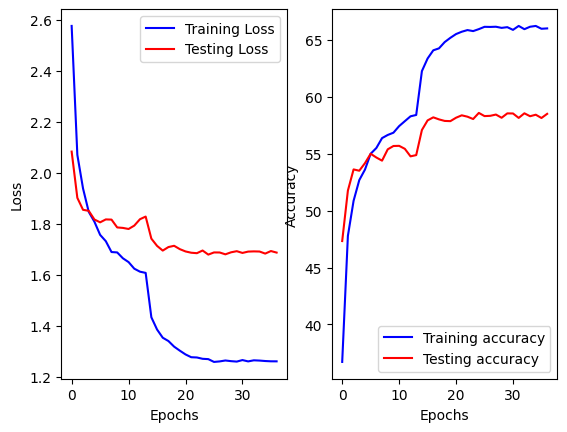

In [ ]:
plot_metrics(metrics, model_name='model_V3')

# Save model
torch.save(model_V3.state_dict(), 'models/model_V3.pth')

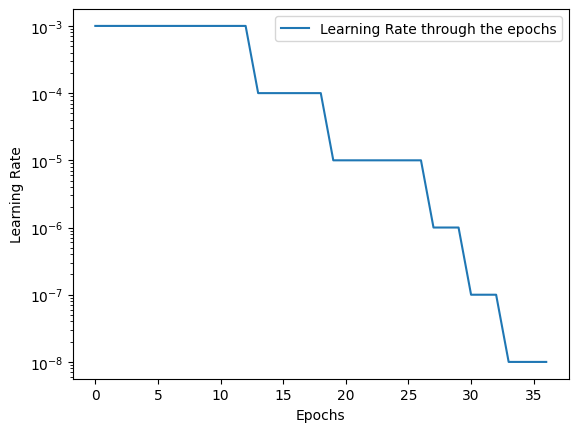

In [ ]:
plt.plot(metrics['epochs'], metrics['lr'], label = 'Learning Rate through the epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.yscale('log')
plt.show()

In [ ]:
# weights = torchvision.models.ViT_H_14_Weights.IMAGENET1K_SWAG_LINEAR_V1 # .DEFAULT = best available weights 
# model_V4 = torchvision.models.vit_h_14(weights=weights).to(device)

In [ ]:
# from torchinfo import summary
# summary(model=model_V4, 
#         input_size=(BATCH_SIZE, 3, img_size, img_size), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )